In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Optional: suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from src.data_loader import load_raw_data
from src.feature_engineering import generate_all_features
from src.train_model import get_feature_target_split, train_lightgbm, train_xgboost, train_catboost

In [3]:
# Load and preprocess
df = load_raw_data("../data/Iphone_Sales.csv")
df = generate_all_features(df)

# Filter out incomplete rows (e.g. early lags)
df = df.dropna(subset=["retail_price", "price_discounted","sales_lag_1", "sales_lag_2", "sales_lag_4", "sales_rolling_mean_4"])

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def forecast_window(train_df, test_df, model_type="lightgbm"):
    X_train, y_train, cat_feats = get_feature_target_split(train_df)
    X_test, y_test, _ = get_feature_target_split(test_df)

    if model_type == "xgboost":
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        for col in cat_feats:
            X_train_encoded[col] = X_train_encoded[col].cat.codes
            X_test_encoded[col] = X_test_encoded[col].cat.codes
        model = train_xgboost(X_train_encoded, y_train, cat_feats)
        y_pred = model.predict(X_test_encoded)

    elif model_type == "lightgbm":
        model = train_lightgbm(X_train, y_train, cat_feats)
        y_pred = model.predict(X_test)

    elif model_type == "catboost":
        model = train_catboost(X_train, y_train, cat_feats)
        y_pred = model.predict(X_test)

    else:
        raise ValueError("Unsupported model_type")

    return y_test.reset_index(drop=True), pd.Series(y_pred, index=y_test.index)

In [15]:
# Forecast settings
horizon = 8
min_train_weeks = 52  # e.g. at least 1 year of training before forecast

# Sort by date for proper windowing
df = df.sort_values(["product_id", "week"])

# Store results
results = []

# Loop over each product_id
for product_id, df_product in tqdm(df.groupby("product_id")):
    df_product = df_product.reset_index(drop=True)

    for start in range(min_train_weeks, len(df_product) - horizon):
        train_df = df_product.iloc[:start]
        test_df = df_product.iloc[start:start + horizon]

        # Skip if test has null sales (i.e. still cold start phase)
        if test_df["sales"].isnull().any():
            continue

        y_true, y_pred = forecast_window(train_df, test_df, model_type="catboost")

        for i in range(horizon):
            results.append({
                "product_id": product_id,
                "week": test_df.iloc[i]["week"],
                "y_true": y_true.iloc[i],
                "y_pred": y_pred.iloc[i]
            })

  0%|          | 0/5 [00:00<?, ?it/s]

[CatBoost] MAPE: 351.11%
[CatBoost] RMSE: 174.24
[CatBoost] MAPE: 349.31%
[CatBoost] RMSE: 183.58
[CatBoost] MAPE: 425.57%
[CatBoost] RMSE: 215.31
[CatBoost] MAPE: 562.40%
[CatBoost] RMSE: 265.34
[CatBoost] MAPE: 570.54%
[CatBoost] RMSE: 272.68
[CatBoost] MAPE: 555.74%
[CatBoost] RMSE: 311.87
[CatBoost] MAPE: 546.10%
[CatBoost] RMSE: 304.66
[CatBoost] MAPE: 470.50%
[CatBoost] RMSE: 264.90
[CatBoost] MAPE: 473.71%
[CatBoost] RMSE: 254.29
[CatBoost] MAPE: 440.80%
[CatBoost] RMSE: 246.34
[CatBoost] MAPE: 196.77%
[CatBoost] RMSE: 201.80
[CatBoost] MAPE: 102.78%
[CatBoost] RMSE: 215.91
[CatBoost] MAPE: 102.26%
[CatBoost] RMSE: 229.85
[CatBoost] MAPE: 75.17%
[CatBoost] RMSE: 186.75
[CatBoost] MAPE: 90.59%
[CatBoost] RMSE: 187.35
[CatBoost] MAPE: 233.27%
[CatBoost] RMSE: 233.74
[CatBoost] MAPE: 346.48%
[CatBoost] RMSE: 235.29
[CatBoost] MAPE: 385.89%
[CatBoost] RMSE: 232.09
[CatBoost] MAPE: 359.54%
[CatBoost] RMSE: 244.02
[CatBoost] MAPE: 342.22%
[CatBoost] RMSE: 241.59
[CatBoost] MAPE: 330.1

Global MAPE: 1244.195417195885
Global RMSE: 711.9574312072259


<Axes: title={'center': 'WAPE per Product'}, xlabel='product_id'>

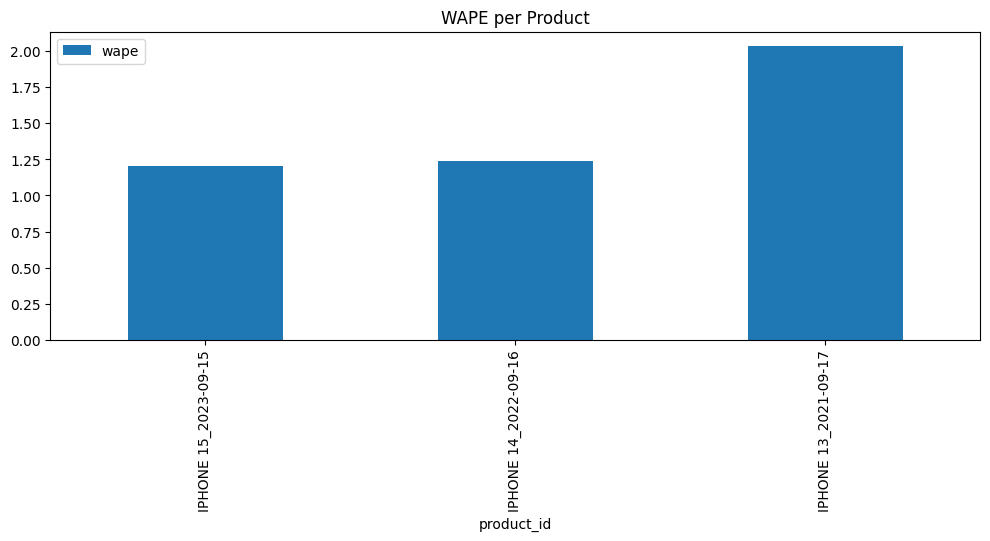

In [16]:
results_df = pd.DataFrame(results)
results_df["abs_error"] = np.abs(results_df["y_true"] - results_df["y_pred"])
results_df["mape"] = np.abs((results_df["y_true"] - results_df["y_pred"]) / (results_df["y_true"] + 1e-9)) * 100

# Global metrics
print("Global MAPE:", results_df["mape"].mean())
print("Global RMSE:", rmse(results_df["y_true"], results_df["y_pred"]))

# Per-product performance
product_metrics = results_df.groupby("product_id").agg({
    "y_true": "sum",
    "abs_error": "sum",
    "mape": "mean"
}).reset_index()
product_metrics["wape"] = product_metrics["abs_error"] / product_metrics["y_true"]

# Visualize
product_metrics.sort_values("wape").plot(x="product_id", y="wape", kind="bar", figsize=(12, 4), title="WAPE per Product")


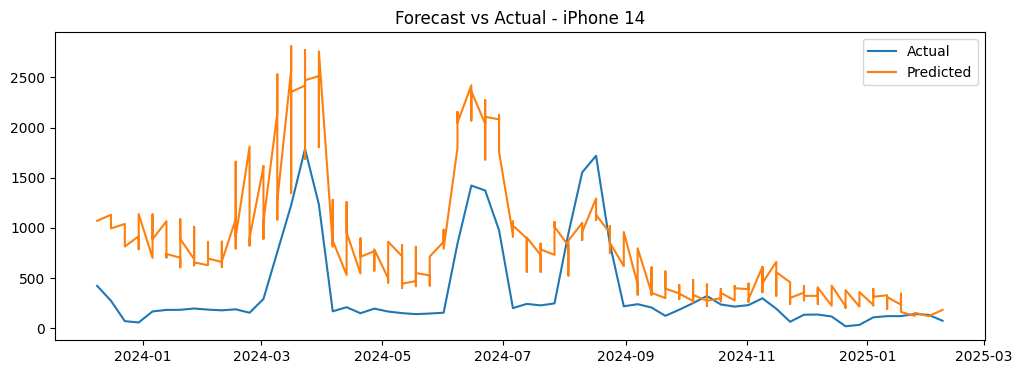

In [17]:
df_plot = results_df[results_df["product_id"] == "IPHONE 14_2022-09-16"]
df_plot = df_plot.sort_values("week")

plt.figure(figsize=(12, 4))
plt.plot(df_plot["week"], df_plot["y_true"], label="Actual")
plt.plot(df_plot["week"], df_plot["y_pred"], label="Predicted")
plt.legend()
plt.title("Forecast vs Actual - iPhone 14")
plt.show()

In [18]:
results_df.head()

,product_id,week,y_true,y_pred,abs_error,mape
0,IPHONE 13_2021-09-17,2023-12-09,298,396.727899,98.727899,33.130167
1,IPHONE 13_2021-09-17,2023-12-16,239,382.158712,143.158712,59.899043
2,IPHONE 13_2021-09-17,2023-12-23,74,378.888229,304.888229,412.011121
3,IPHONE 13_2021-09-17,2023-12-30,52,318.832775,266.832775,513.139952
4,IPHONE 13_2021-09-17,2024-01-06,217,692.251648,475.251648,219.009976
